In [19]:
import torchvision.transforms
import source.data
import source.utils
import matplotlib.pyplot as plt
import torch.hub
import torch.utils.data
import torch
import torch.optim
import source.modules
import source.constants
import torchvision.models.segmentation
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
_  = torch.manual_seed(0)

cpu_device = torch.device('cpu')
device = torch.device('cuda:0')

torch.cuda.empty_cache()

In [4]:
image_transform = torchvision.transforms.Compose(
    [
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((336, 448)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(lambda image_as_int_tensor: image_as_int_tensor / 255.),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((336, 448)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(
        lambda mask_as_int_tensor: mask_as_int_tensor.squeeze().type(torch.LongTensor)
    ),
])

dataset = source.data.AugmentedPascalPartDataset(
    transform=image_transform,
    target_transform=mask_transform
)

dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=6)

weights = torchvision.models.segmentation.FCN_ResNet101_Weights.DEFAULT
model = torchvision.models.segmentation.fcn_resnet101(weights=weights, progress=False)

classifier = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    torch.nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1, inplace=False),
    torch.nn.Conv2d(512, 7, kernel_size=(1, 1), stride=(1, 1))
)

model.classifier = classifier
model.aux_classifier = None

checkpoint = torch.load(f"{source.constants.REPOSITORY_ROOT}/checkpoints/resnet101.pth")
model.load_state_dict(checkpoint['model'])
_ = model.to(device)

/tmp/ipykernel_144692/3147579155.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"{source.constants.REPOSITORY_ROOT}/checkpoints/resnet101.pth"

In [5]:
evaluation_dataset = source.data.PascalPartDataset(
    transform=image_transform,
    train=False,
)
_ = model.eval()
evaluation_metrics_tracker = {index:[] for index in range(0, 10)}

In [7]:
index_to_loss: dict[int, list[float]] = {}

with torch.no_grad():
    for index, (image, mask) in enumerate(evaluation_dataset):
        image = image.to(device)
        mask = mask.to(device)
        
        mask_shape = mask.shape
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output_logits = model(image)['out']

        log_probabilities = torch.nn.functional.log_softmax(
            output_logits,
            dim=1, # 1 x C x H x W
        )

        upsampled_log_probabilities = torch.nn.functional.interpolate(
            input=log_probabilities,
            size=mask_shape,
        )

        intersection_over_union_per_class = source.utils.log_probabilities_and_mask_iou_per_class(
            log_probabilities=upsampled_log_probabilities,
            masks=mask,
            classes=list(dataset.class_to_name.keys()),
        )

        index_to_loss[index] = []
        
        for object_class in range(0, 10):
            filtered_iou = intersection_over_union_per_class[object_class][
                intersection_over_union_per_class[object_class] >= 0.
            ].to(cpu_device).detach()

            if filtered_iou.numel():
                metric = filtered_iou.mean().item()
                evaluation_metrics_tracker[object_class].append(metric)
                index_to_loss[index].append(metric)
            else:
                index_to_loss[index].append(1.)

In [12]:
body_metrics = torch.Tensor([metrics[9] for _, metrics in index_to_loss.items()])
lower_body_metrics = torch.Tensor([metrics[8] for _, metrics in index_to_loss.items()])
upper_body_metrics = torch.Tensor([metrics[7] for _, metrics in index_to_loss.items()])

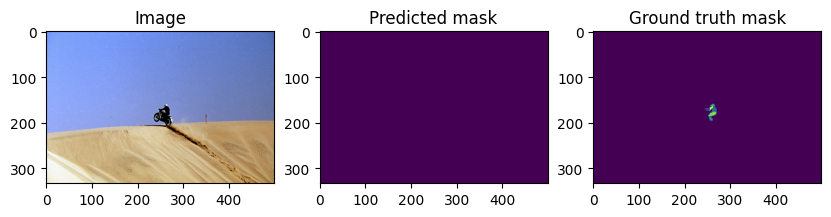

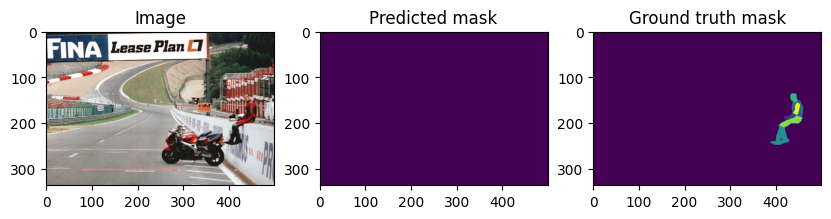

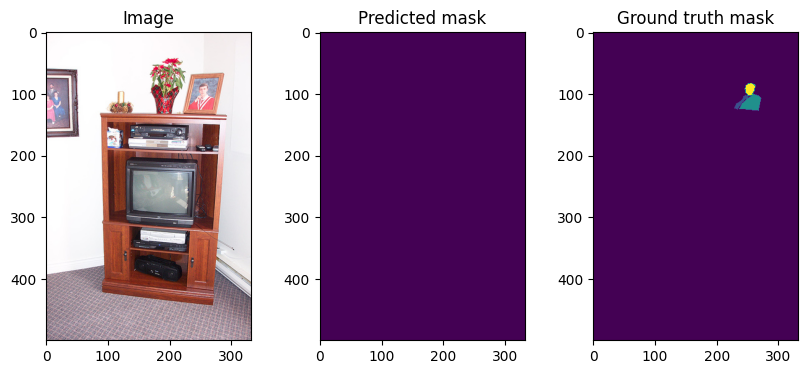

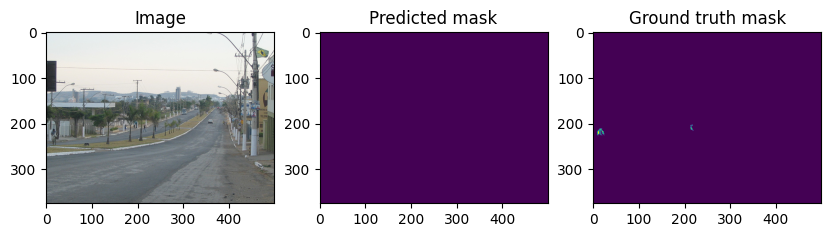

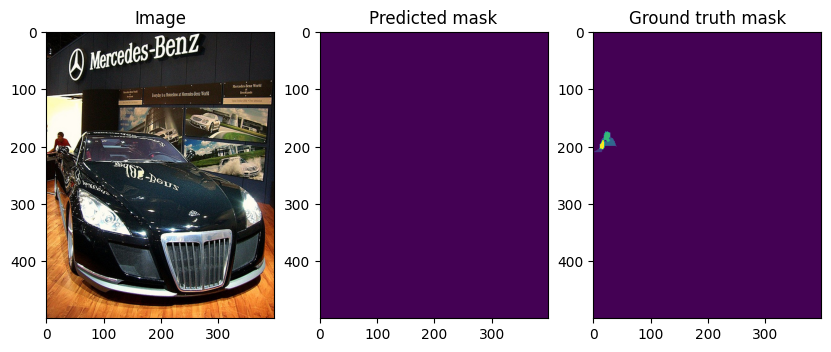

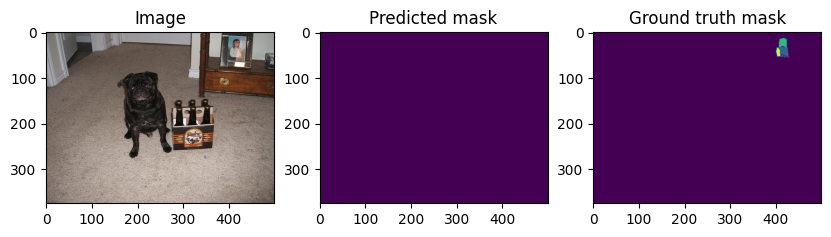

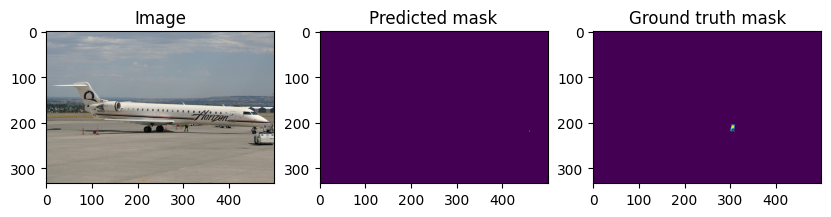

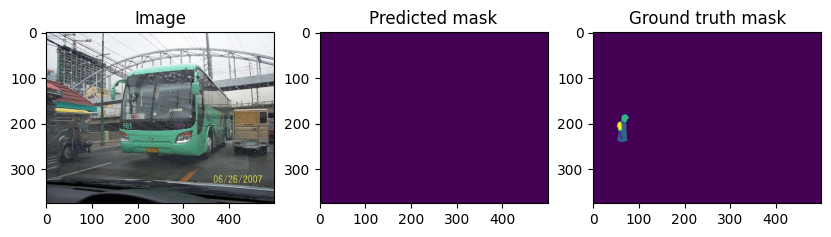

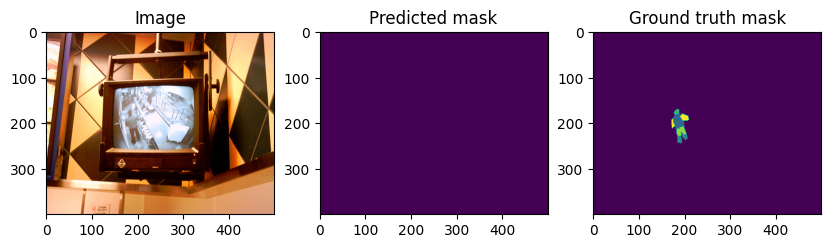

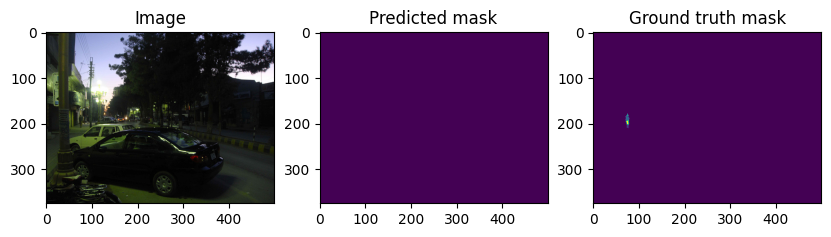

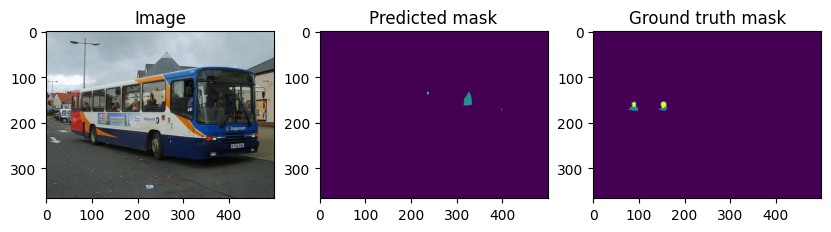

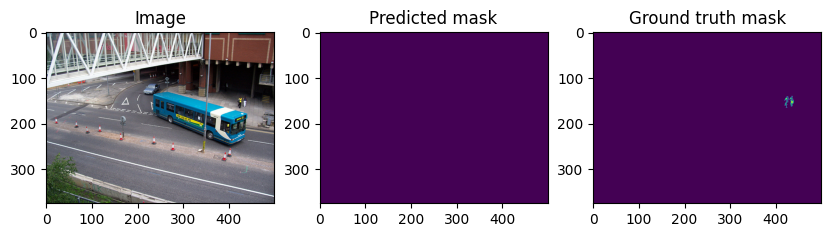

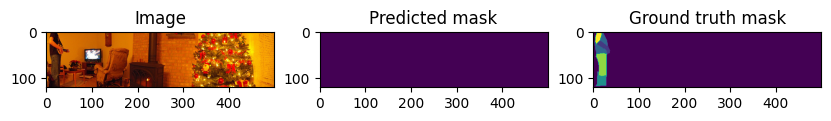

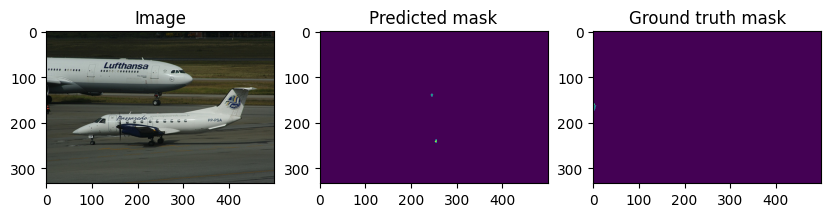

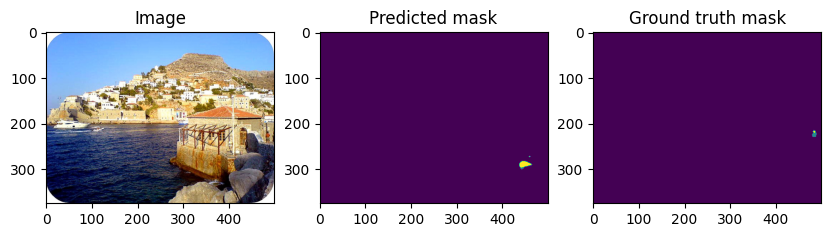

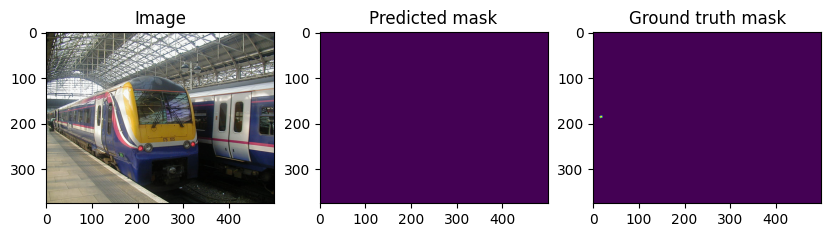

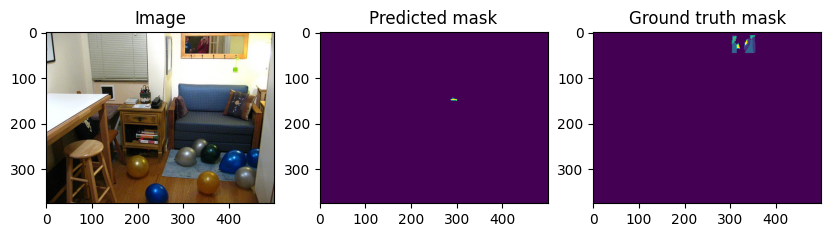

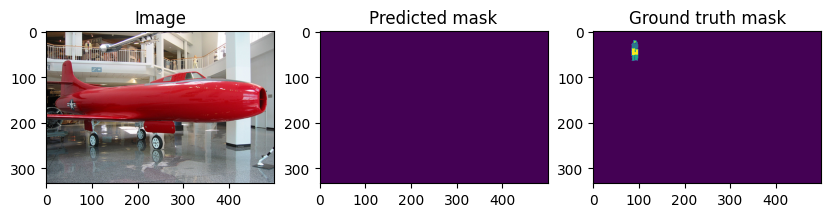

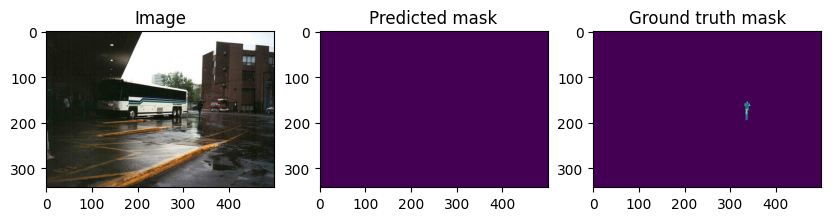

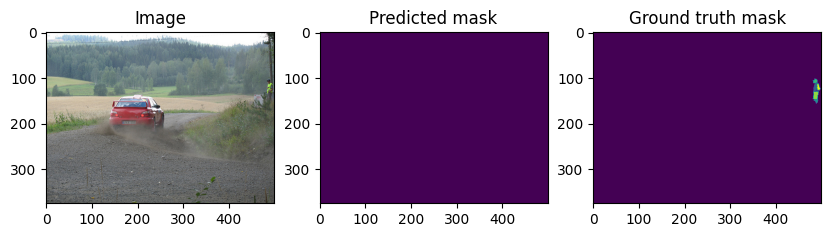

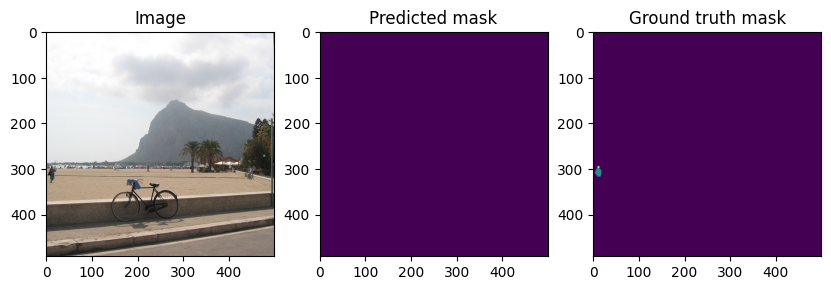

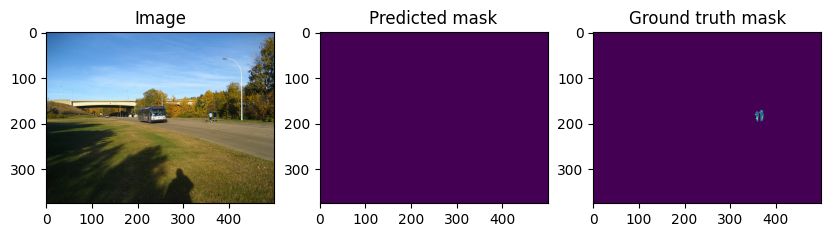

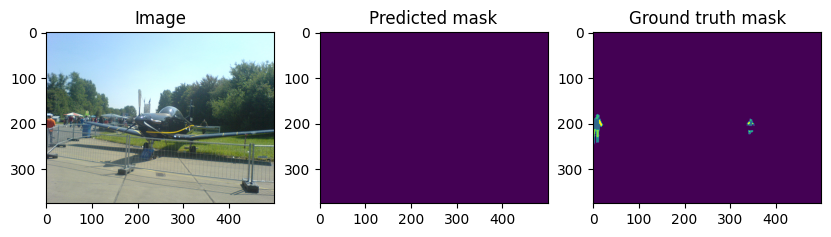

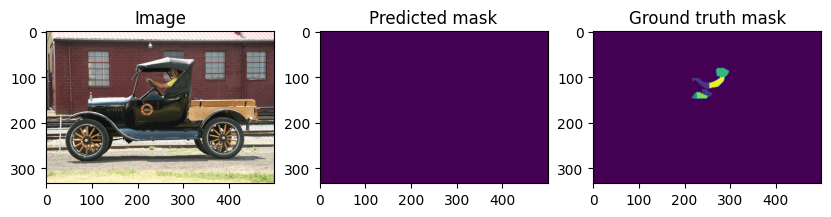

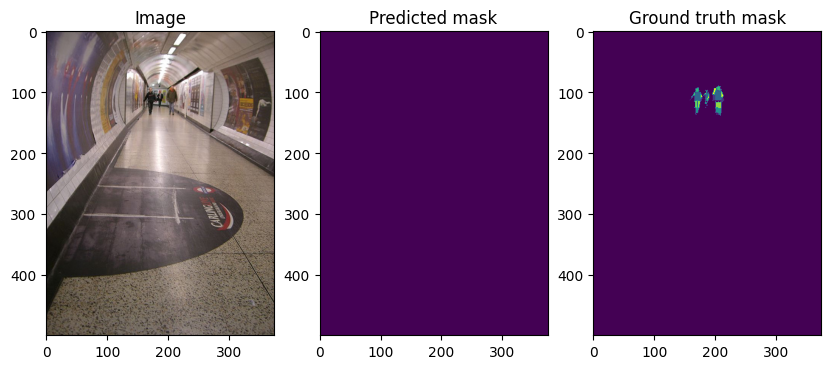

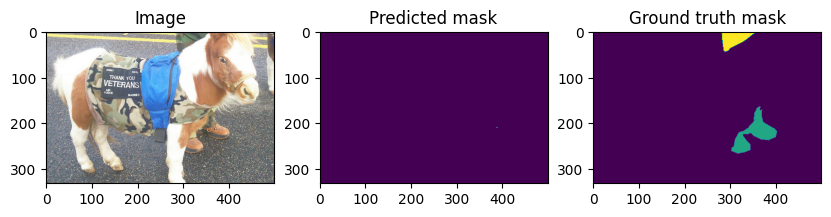

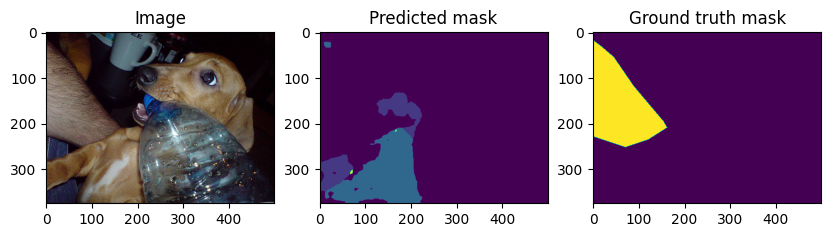

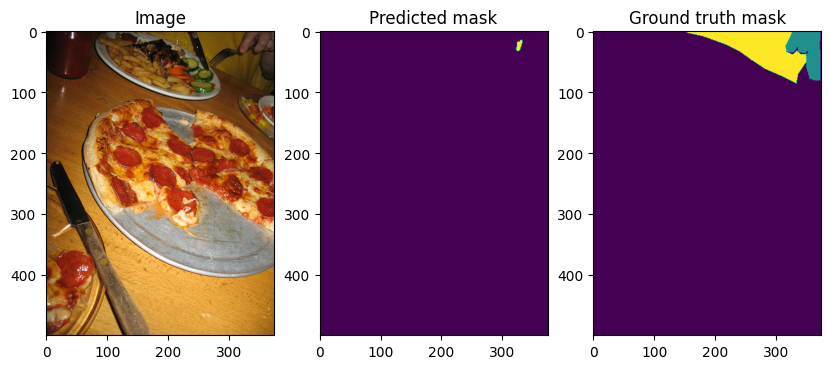

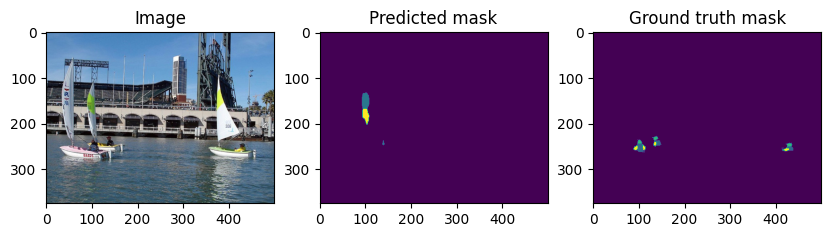

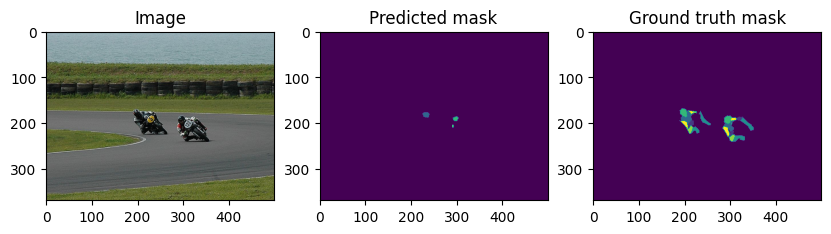

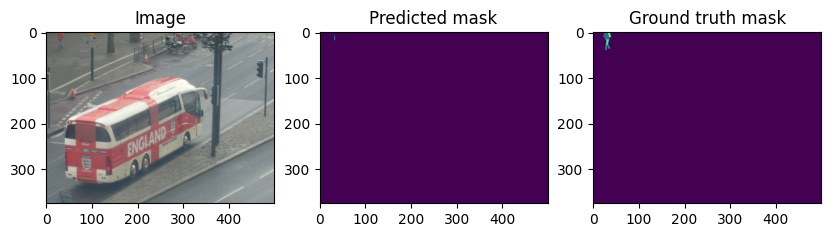

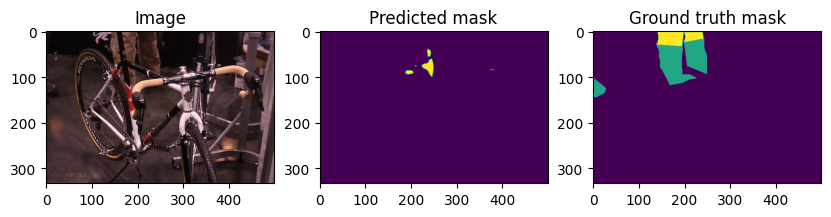

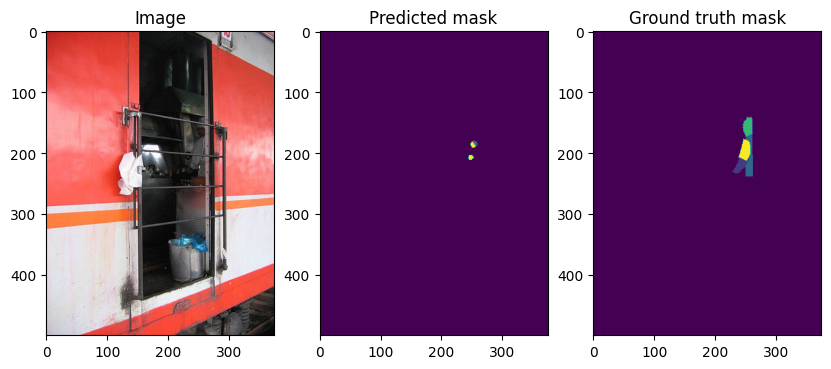

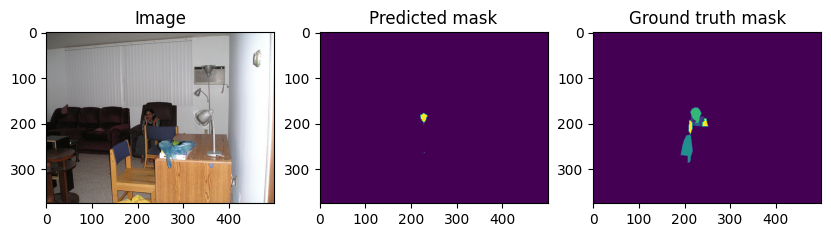

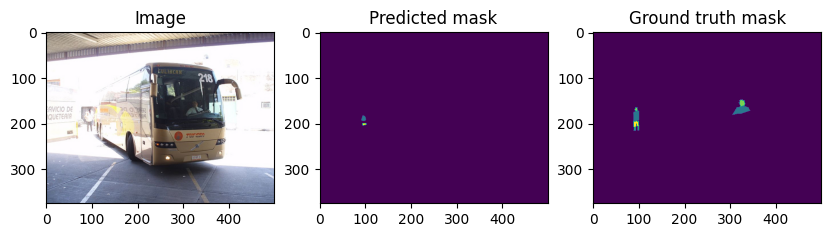

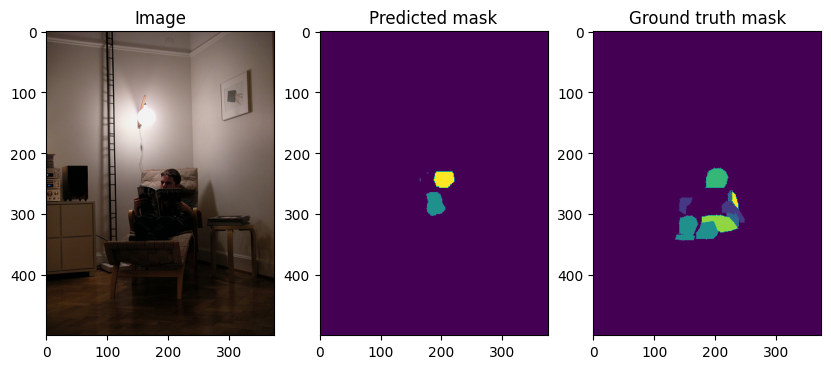

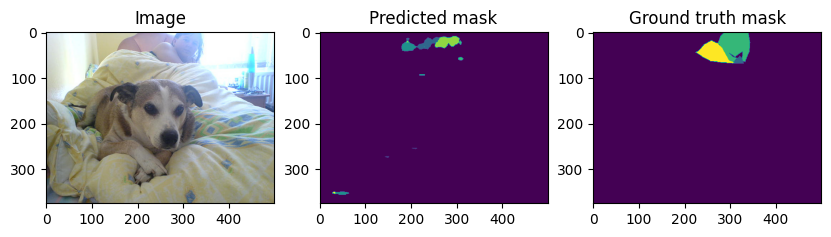

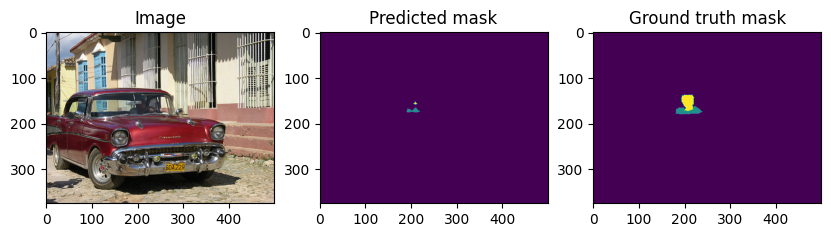

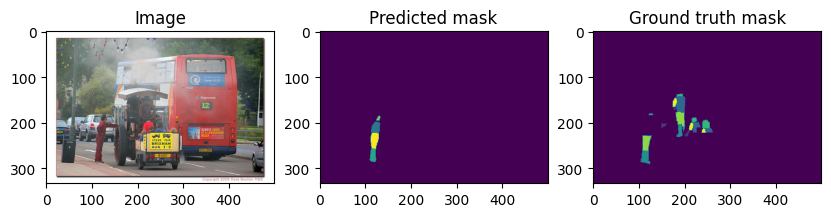

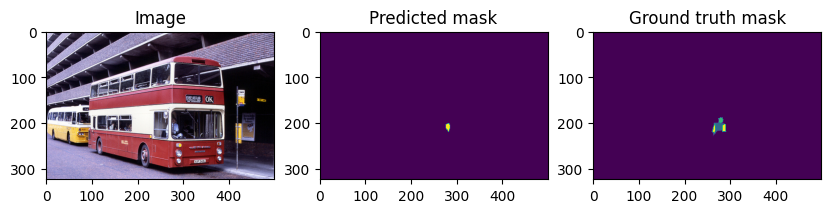

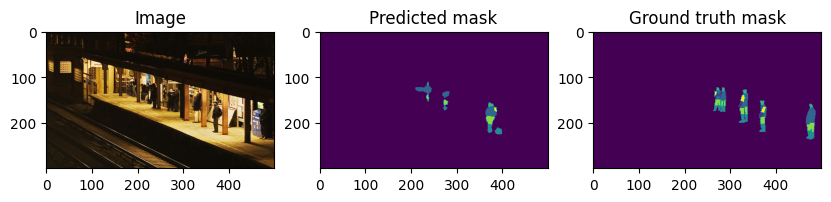

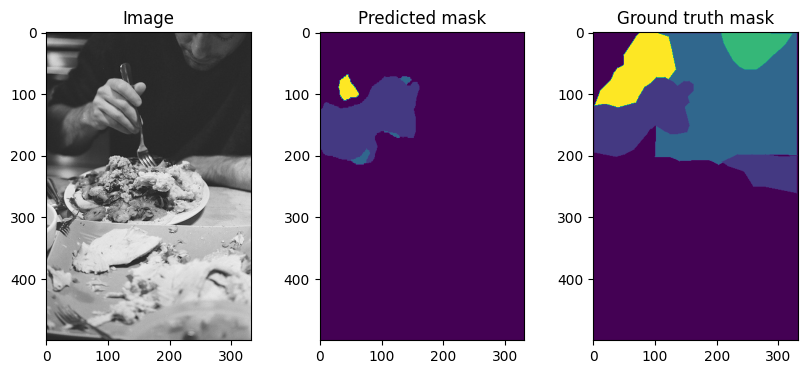

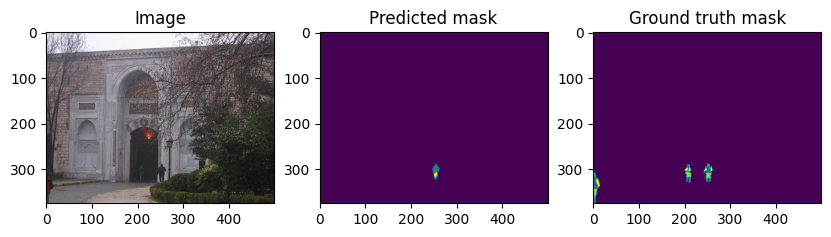

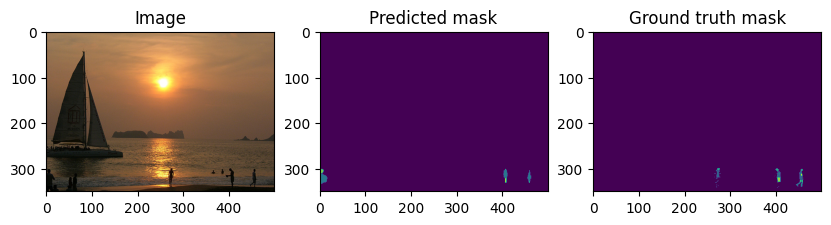

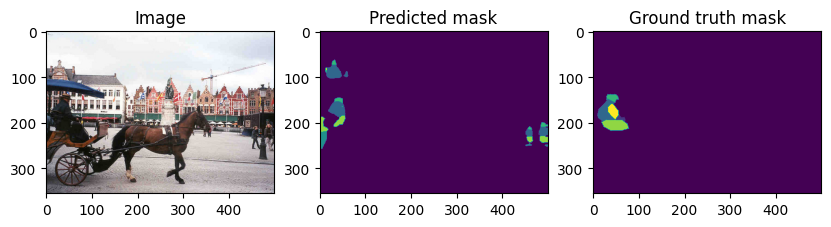

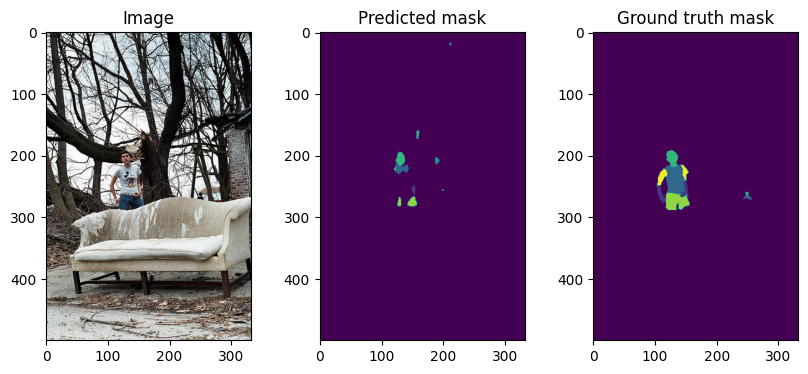

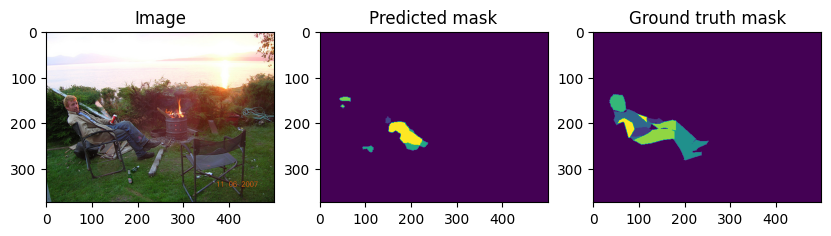

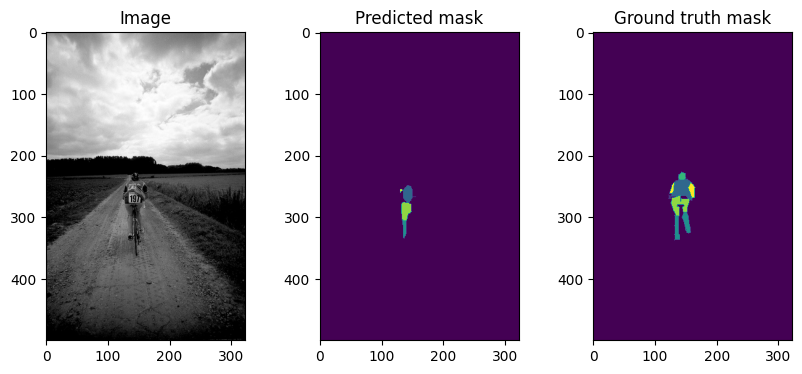

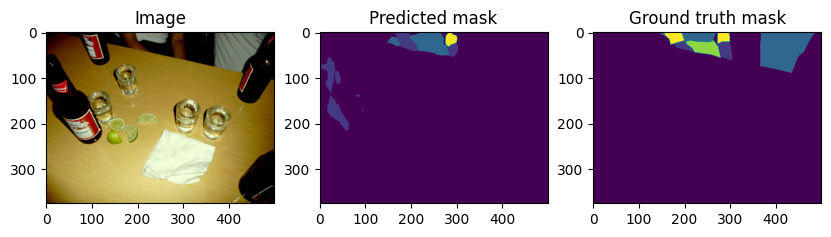

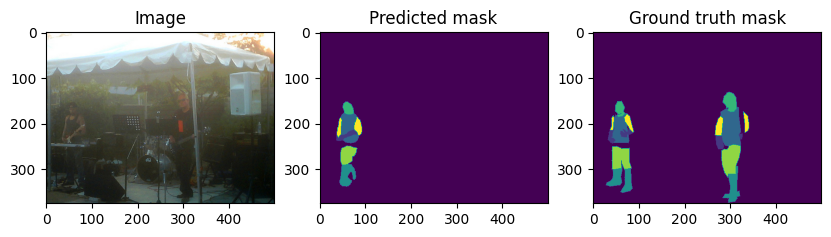

In [21]:
total_failures = body_metrics.argsort()[:50]

for index in range(50):
    random_index = total_failures[index]
    original_image, original_mask = source.data.PascalPartDataset(train=False)[random_index]
    mask_shape = original_mask.shape
    image = image_transform(original_image).unsqueeze(0)
    mask = mask.unsqueeze(0)

    image = image.to(device)
    output_logits = model(image)['out']


    log_probabilities = torch.nn.functional.log_softmax(
        output_logits,
        dim=1, # 1 x C x H x W
    )
    upsampled_log_probabilities = torch.nn.functional.interpolate(
        input=log_probabilities,
        size=mask_shape,
    )
    predicted_mask = upsampled_log_probabilities.argmax(
        dim=1
    ).squeeze().to(cpu_device)

    figure = plt.figure(figsize=(10, 4))

    figure.add_subplot(1, 3, 1)
    plt.imshow(original_image.squeeze().permute(1, 2, 0))
    plt.title("Image")

    figure.add_subplot(1, 3, 2)
    plt.imshow(predicted_mask)
    plt.title("Predicted mask")

    figure.add_subplot(1, 3, 3)
    plt.imshow(original_mask.squeeze())
    plt.title("Ground truth mask")

    plt.show()